# Project 1: Assembling Genomes


   <div class="alert alert-block alert-danger">
    <center>Due: <b>Tuesday, 8 February, 4:59pm</b>.</center> 
   </div>
   
   <div class="alert alert-block alert-warning">
   <center>
       <b>Collaboration and Resource Policy</b>
    </center>
    For this assignment, you are encouraged to work with one other person. Your team must satisfy the constraints mentioned in <a href="https://www.dropbox.com/s/g6z2xncwc4jsplp/csbio-class2-inked.pdf?dl=0">Class 2</a>.
    
   1. You went to different high schools.
   2. You and your partner have different answers to <em>at least one</em> of these questions:
       - What country were you born in?
       - Have you taken any biology courses at UVA?
       - Have you taken cs3102?
       - Have you taken cs4102?
    
We expect most students will have the best learning experience on this assignment by working with a partner, but if you prefer to work alone it is okay to do this assignment on your own.
    
You are permitted (actually _encouraged_) to discuss these problems with anyone you want, including other students in the class. If you do discuss the specific questions in the assignment with anyone other than your assignment partner and the course staff, though, you should list them in the _External resources used_ section below.
    
You are welcome to use any resources you want for this assignment, other than ones that would defeat the purpose of the assignment. This means you should not look at answers or code from any other students in the class (other than your collaboration with your partner), and if you find code that implements the problem you are being asked to do for the assignment, you should not use that code. You should document all external resource you use that are not part of the course materials in the _External resources used_ section below.

**Team submitting this assignment:**  
<div class="alert alert-success">
    <b><em>Yuchen Sun (ys4aj)</em></b>
</div>

**External resources used:** 
<div class="alert alert-success">
<em>It is not necessary to list the course materials, but if you used any other resources, including discussing problems with students not on your team, list them here.</em>
</div>

In this project, we will explore genome assembly — the process of determining the order of nucleotides from fragmented reads that are produced by sequencing machines. 

Genome assembly maps to a very well defined computer science problem, but can get quite complicated, as problems such as full sequence coverage, finding a good length for reads (the $k$ in $k$-mer), and sequencing errors present challenges for sequencing analysis and accuracy. For the required problems (ones everyone is expected to solve), you will be able to assume perfect coverage and no read errors; for the "challenge" problem (that is considered a bonus, and not something we expect everyone to be able to solve, and perhaps may not even be feasible for anyone to solve) you will not be able to rely on such assumptions.

 <div class="alert alert-block alert-warning">
    
<b>Submission</b>: You should work on this assignment by forking the provided Project 1 repository (you probably already did this, following the instructions posted at [https://computingbiology.github.io/project1](https://computingbiology.github.io/project1). Add the other teammate to as a collaborator with write access (also under the Settings tab) to this repository.
    
You should answer the questions and write your code in this Jupyter Notebook. (We don't expect you to need to use any external files or organize your code outside of the notebook, but if you do, make sure to put everything needed to run your code in your repository.) Parts where you are expected to provide and answer (which could be text that can be written in markdown format in the notebook or Python code that runs in the notebook) are marked in green.
        
When you are ready to submit the assignment, you should create a release of the version you are submitting ([github's directions for how to create a release](https://docs.github.com/en/repositories/releasing-projects-on-github/managing-releases-in-a-repository)) tagged as `submit`. After you've done this, send a message in slack to a channel that includes both team members (so the one sending this message should include the other team member) and all of the course staff (`dave`, `Hyun Jae Cho`, and `Anshuman Suri`) and a link to your repository (feel free to add any other useful comments if you want, but the link to your submission repository is sufficient).

## Getting Started

1. Install basic required packages, should be run only once. You may need to restart the jupyter python kernel (under the Kernel menu) after this. (You can execute this directly in the notebook but running the command below.)

In [1]:
!pip install -r requirements.txt

2. Make sure you have [graphviz](https://graphviz.org/) installed on your system. (On a Mac OS X, `brew install graphviz`. For other platforms, see [_https://graphviz.org/download/_](https://graphviz.org/download/).)

In [2]:
import collections
import matplotlib.pyplot as plt

import utils

import numpy as np
import collections
import random
from tqdm import tqdm

## Part 1: Assembling the TeleTubby Genome

For this part, you're given reads generated while trying to sequence the DNA of a mysterious unknown organism with a _tiny_ genome. Some of the course staff is not sure what a TeleTubby is, but I've been assured that no cute creatures were harmed in producing this data (which was generated synthetically).

By answering the following questions, you will learn how to assemble the original genome sequence from sequence reads.

Sequencing data is often stored in the FASTQ file format, with is a simple ASCII format that is somewhat human-readable. 

In _TeleTubby.fastq_ (which is included in the repository you forked), you will find the data that was read from the TeleTubby genome. Each four lines of the file repeat the same pattern. For example,
```
@TeleTubby Genome: Project 1
TAAAATGG
+
HAICDF5I
```
The first line contains the metadata that encodes the name of the read, the experiment type, the kind of sequencing machine used, etc. 

The second line is the sequence of bases that was read. 

The third line is just a placeholder.

The fourth line is a sequence of base qualities that encodes the qualities for the corresponding bases in the sequence line. We will discuss and use this for Problem 2.

Read in the data from `TeleTubby.fastq`:

In [3]:
# Read sequence reads (error-free) from file
sequence_reads, qualities = utils.read_fastq('TeleTubby.fastq')

### Melting Temperature

The GC-content (or the ratio of G and C nucleotides) is related to the melting temperature of a DNA double helix structure. 

The following equation can be used to estimate the melting temperature (in degrees Celsius) of DNA for a particular sequence:

\begin{equation*}
t_m = 64.9+0.41(\%GC)-\frac{500}{\text{length of sequence}}
\end{equation*}

As a reference, the human genome is known to have between 35%-60% GC-content. 

<div class="alert alert-success">

**Problem 1.** Calculate the melting temperature for the TeleTubby genome using the formula above. Assume that the sequence is 200 nucleotides long, and that the provided read data has equal coverage everywhere so the G-C distribution in the reads is very close to the actual G-C distribution for the genome. 
    </div>

In [4]:
# Write code here for calculating the %GC content from the sequence_reads, and computing the estimated melting temperature.
gc, total = 0, 0
for read in sequence_reads:
    total += len(read)
    for base in read:
        if base == 'G' or base == 'C':
            gc += 1
pGC = gc/total
print(pGC)

0.4987244897959184


In [5]:
# Print out temperature in Celsius
temp = 64.9+0.41*pGC-500/200
print(temp)

62.604477040816334


## Interpreting Read Quality

Phred33 quality scores are represented as the character with an ASCII code equal to its value + 33 (to make them easy to print alongside genome sequences). The Phred scores $Q$ are related to error probabilities $P$ as: $Q = -10 \log_{10}(P)$. The table linked here provides a mapping from the Phred values provided in a fastq file and the $Q$ values: [Quality Score Encoding](https://support.illumina.com/help/BaseSpace_OLH_009008/Content/Source/Informatics/BS/QualityScoreEncoding_swBS.htm) 

<div class="alert alert-success">
    
**Problem 2.** Using the Phred scores, identify the _least likely to be correct_ read in the TeleTubby.fastq data, which is the read with the lowest probability that it contains _no_ errors.

</div>

In [6]:
# Write your code for Problem 2 here.
pReads = []
for phred in qualities:
    prob = 1
    for base in phred:
        Q = ord(base)-33
        P = 10**(-Q/10)
        prob *= P
    pReads.append(prob)
# It should output the read (nucleotide sequence) with the lowest probability of containing no errors.
print(sequence_reads[pReads.index(max(pReads))])

ATCCCCCG


Note: For the following problems, you can ignore the read quality scores, and safely assume there are no actual errors in the provided TeleTubby reads.

## Frequency analysis

Looking at repetitions in the sequence can be helpful in estimating the "redudancy" in the organisms. Eucaryote genomes have a lot of redundancy, while smaller organisms like bacteria have highly packed genomes. One heuristic to estimate this before actually performing the assembly could be looking at how often certain $k$-mers are repeated.

<div class="alert alert-success">
    
**Problem 3.**
    Print out the 3 most frequent <em>k</em>-mers in the TeleTubby reads with their frequencies. (As in Problem 1, doing this from the reads only produces the same result as from the genome if the read coverage is equal everywhere, but it should be a close estimate.)
</div>

In [7]:
# Your code here
repeats = collections.Counter(sequence_reads)
repeats = sorted(repeats.items(), key=lambda i: i[1], reverse=True)
for a in range(3):
    print(repeats[a])

('ATAAAATG', 2)
('GTGATAGG', 2)
('TAATTTTT', 2)


## Greedy Assembly

Given a set of sequence fragments, the objective of assembly can be viewed as finding the shortest sequence that contains all the fragments.

One of the approaches to assemble the genome from the given reads is a greedy algorithm:

```
while (len(fragments) > 1):
   calculate pairwise alignments of all pairs of fragments
   merge the two fragments with the largest overlap
genome = fragment[0] # the single remaining fragment is the genome
```


<div class="alert alert-success">
    
**Problem 4 (a)**. What would the runtime be of this algorithm, given $n$ $k$-mer reads? (If you are not sure how to express your answer to this question, review [_Cost of Computation_](https://computingbiology.github.io/complexity/).)
    </div>

<i>Answer</i>: O(n^3)

<div class="alert alert-success">

**Problem 4 (b)**. Is this algorithm guaranteed to find the correct genome? (A good answer will define what _correct_ means here, and explain why the algorithm is or is not guaranteed to find it.)

<i>Answer</i>: It doesn't guarantee the correct genome. Because it's not always the case that the two most overlapped fragments should be merged together.

## Graph-based Assembly

Graphs for genome assembly can be constructed in two ways:

- de Bruijn graph: Processing $k-$mers as nodes, with $(k-1)-$mers as edges, and
- Overlap graph: Processing $k-$mers as edges, with $(k-1)-$mers as nodes.

A de Bruijn graph can be processed to find Euler paths, while Overlap graphs can be processed to find Hamiltonian paths. Both of these methods can be used reconstruct the original genome.

<div class="alert alert-success">
    
**Problem 5.**  Use one of these two techniques to reconstruct the TeleTubby genome from the provided sequence reads. 
    
</div>
    
We have provided some template code below that may be helpful (but feel free to ignore this is you prefer).

In [8]:
# Read reads into graph

def build_graph(k_mers):
    edges = []
    nodes = set()
    # Your code here
    unique_seqs = list(set(k_mers))
    for read in unique_seqs:
        prefix, postfix = read[:-1], read[1:]
        nodes.add(prefix)
        nodes.add(postfix)
        edges.append([prefix,postfix])
    return nodes, edges

In [9]:
nodes, edges = build_graph(sequence_reads)

In [10]:
# Needed to properly visualize graphs
%load_ext gvmagic

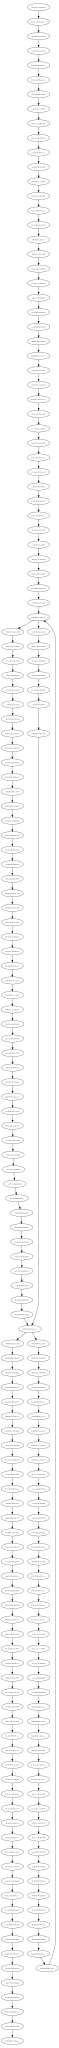

In [11]:
# Helper function to visualize graphs
%dotstr utils.viz_graph(nodes, edges)

In [12]:
# Main assembly algorithm

def hasedge(adjlist):
    for n in adjlist.keys():
        if adjlist[n]: return True
    return False

def getstart(adjlist,current_path):
    for n in adjlist.keys():
        if adjlist[n]: 
            if (not current_path) or (n in current_path): return n
    return None
    
def find_cycle(nodes,adjlist,current_path):
    start = getstart(adjlist,current_path)
    prev_node = start
    next_node = ''
    path = []
    while hasedge(adjlist) and next_node != start:
        next_node = random.choice(adjlist[prev_node])
        adjlist[prev_node].remove(next_node)
        path.append(next_node)
        prev_node = next_node
    return path, adjlist

def assemble_sequence(nodes, edges):
    assembled_sequence = ""
    # Your code here
    nodes = list(nodes)
    degree, adjlist = {}, {}
    for n in nodes:
        degree[n] = 0
        adjlist[n] = []
    for src, dst in edges:
        adjlist[src].append(dst)
        degree[src] -= 1 # out
        degree[dst] += 1 # in
    
    sorted_degree = sorted(degree.items(),key=lambda d: d[1])
    start, end = sorted_degree[0][0], sorted_degree[-1][0]
    adjlist[end].append(start) # make a eulerian cycle
    
    final_path = []
    
    while hasedge(adjlist):
        # get one cycle
        cycle_path, adjlist = find_cycle(nodes,adjlist,final_path)
        # merge cycle path to final path
        if not final_path:
            final_path = cycle_path
        else:
            insloc = final_path.index(cycle_path[-1])+1
            cycle_path.reverse()
            for c in cycle_path:
                final_path.insert(insloc,c)
    
    # assemble sequence from final path
    istart = final_path.index(start)
    assembled_sequence = start
    for i in range(1,len(final_path)):
        inext = (istart+i)%len(final_path)
        assembled_sequence += final_path[inext][-1]
    
    return assembled_sequence

In [13]:
# Output assembled sequence
# Hint: Sequence is 200 nucleotides long

assmebled_seq = assemble_sequence(nodes, edges)
print(assmebled_seq)
print('seq length:',len(assmebled_seq))

CCTACCGACGAATGTCATGCACATGGCCCCACCACGTATCCATCGTACAGGTGTCGATGGTAAACCTGTTGATAAAATGGCCACATAATTTTTGGTCGTACATCCCCCGCGCATCGTGTTATGCCAACGCTTACATAGGGGATTGTGTCGAGTGATAGGTGACTCGGAGGATCACTTTAACGACCACGGACTCCGGTAGA
seq length: 200


<div class="alert alert-success"> 
    
**Problem 6.** Which of the two assembly methods did you use for problem 5, and why? (Hint: consider how the costs scale with the number of reads.)
    
</div>

<i>Answer</i>: I used de Bruijn Graph and Euler paths.de Bruijn graphs are smaller than the Overlap graph in the case when the number of reads are small.

## Part 2: Sequencing SARS-CoV-2 virus

Let's move on from TeleTubbies to real-world organisms. For this problem, you'll assemble a genome for a variant of the SARS-CoV-2 virus. You're given reads from <i>actual</i> genome sequencing runs in the provided `SARS-CoV2.fastq` file. The file is based on the first Covid genome that was submitted on 5 January 2020: [https://www.ncbi.nlm.nih.gov/nuccore/NC_045512](https://www.ncbi.nlm.nih.gov/nuccore/NC_045512) But, you should be reconstructing a sequence from the provided reads without looking at the source sequence.

<div class="alert alert-success">
    
**Problem 7.**  Reconstruct the SATS-CoV2 genome from the provided sequence reads using $k=25$. 
    
</div>

You can re-use your implementation from Problem 5 and simply run it on the new data (depending on what you did for Problem 5, that might be enough to solve this problem). 

Print out your reconstructed sequence to a file `output.txt` (and add this file to the repo you submit). For this part, we will still assume that all the reads are error-free. 

In [14]:
# Read sequence reads
sequence_reads_covid, qualities_covid = utils.read_fastq('SARS-CoV2.fastq')

In [15]:
# Read reads into graph
nodes_covid, edges_covid = build_graph(sequence_reads_covid)

In [16]:
# Call main assembly algorithm
assmebled_covid_seq = assemble_sequence(nodes_covid, edges_covid)

In [17]:
# Write assembled sequence to file
with open("output.txt", "w") as f:
    f.write(assmebled_covid_seq)

# Part 3: Error-Aware Assembly (Challenge Problem)

<div class="alert alert-warning">
    This problem is a "Challenge Problem". This means it is a problem of unknown difficulty that might be quite challenging (unlike the earlier problems, we don't have a reference solution for this one, or a clear idea how hard it might be). We do hope all students will at least attempt this and that more ambitious students will work hard to solve it and learn interesting things by the attempt (whether or not it is successful), but not get frustrated if you can't get to the desired answer.  As a "Challenge Problem" it means that you shouldn't be worried if you are not able to solve this, though, and you can get full expected credit on this assignment without answering it.
</div>


In the parts above, we assumed error-free reads while assembling $k$-mers. As much as we'd like that, actual reads can (and do) have errors, captured by their Phred scores. 

For this question, you're given raw, actual reads from sequencing runs. Download the reads from this file:
https://sra-pub-sars-cov2.s3.amazonaws.com/sra-src/SRR11528307/ABS2-LN-R1_cleaned_paired.fastq.gz.  


<div class="alert alert-success">
    
**Problem 8 (Challenge).** Give the reads in the linked fastq file above, including their Phred33 quality score, assemble the most likely genome. Your solution should output the assembled sequence in `challenge.txt`. Provide a brief explantion of how your algorithm works and interesting things you learned in developing it.
    
</div>
    
This is an open-ended question. You are free to use any approach to deal with the issue. Make sure you provide your code, along with any assumptions you may have.

_Write a description of your algorithm, and things you learned from working on this here._

<h4>Description</h4>
<br>First of all, the fastq file has long and short sequence reads. It could be that the errors exist in the middle of a long sequence, so it's best to treat them as contigs and separate them to k-mers. For sequence reads with length < k, they could be ignored because they can be treated as redundancy.</br>
<br>Then, all k-mers can be assembled in a way similar to the De Bruijn Graph used in the previous cases. However, to prevent the bubbles from disturbing the assembly, I choose to use a weighted version of the De Bruijn Graph. So in this case, each k-mer can use its Phred33 quality score as its path length. For example:</br>
<br>Sequence AB can be represented by edge(A, B, Phred33(AB))</br>
<br>In this way, the problem would be solved by finding the shortest Euler's path in the De Bruijn Graph. A remaining problem is that the bubbles would make the graph not eulerian, so it would also be better to remove the bubbles first. This involves an algorithm to identify the bubbles and to compare their path lengths, and remove the one with higher cost (in this case, more likely to contain an error).</br>
<br>I jammed at the second part of really assembling the sequences, so I just put the code for the first part here, where I generated k-mers from the contigs and created the nodes and edges accordingly.</br>

In [ ]:
# implementation
sequence_reads_err, qualities_err = utils.read_fastq('ABS2-LN-R1_cleaned_paired.fastq.gz')

In [ ]:
lens = []
for i in tqdm(sequence_reads_err):
    lens.append(len(i))
print(collections.Counter(lens))

In [ ]:
def generate_kmers(sequence_reads_err, qualities_err, k=10):
    seq_reads_kmer, qualities = [], []
    for i in tqdm(range(len(sequence_reads_err)),desc='processing reads to kmers'):
        if len(sequence_reads_err[i]) >= k:
            read, quality = sequence_reads_err[i], qualities_err[i]
            for j in range(len(read)-(k-1)):
                seq_reads_kmer.append(read[j:j+k])
                qs = quality[j:j+k]
                prob = -np.array([ord(q)-33 for q in qs]).sum()/10
                qualities.append(prob)
    return seq_reads_kmer, qualities


def build_graph_weighted(k_mers, qualities):
    edges = []
    nodes = set()
    for i in tqdm(range(len(k_mers)),desc='creating nodes and edges'):
        k_mer, quality = k_mers[i], qualities[i]
        prefix, postfix = k_mer[:-1], k_mer[1:]
        nodes.add(prefix)
        nodes.add(postfix)
        edges.append([prefix,postfix,quality]) # src, dst, logprob
    return nodes, edges
    

In [ ]:
seq_reads_kmer, qualities = generate_kmers(sequence_reads_err,qualities_err,50)

In [ ]:
nodes, edges = build_graph_weighted(seq_reads_kmer,qualities)
for i in range(10):
    print(edges[i])

   <div class="alert alert-block alert-danger">
    <center>
        
 **Remember to follow the submission directions above to submit your assignment by 4:59pm on Tuesday, 8 February.**
    
 </center>
 </div>